# 8. Graphical Models

In [1]:
%matplotlib inline
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from prml import bayesnet as bn


np.random.seed(1234)

In [2]:
b = bn.discrete([0.1, 0.9])
f = bn.discrete([0.1, 0.9])

g = bn.discrete([[[0.9, 0.8], [0.8, 0.2]], [[0.1, 0.2], [0.2, 0.8]]], b, f)

In [3]:
print("b:", b)
print("f:", f)
print("g:", g)

b: DiscreteVariable(proba=[0.1 0.9])
f: DiscreteVariable(proba=[0.1 0.9])
g: DiscreteVariable(proba=[0.315 0.685])


In [4]:
g.observe(0)

In [5]:
print("b:", b)
print("f:", f)
print("g:", g)

b: DiscreteVariable(proba=[0.25714286 0.74285714])
f: DiscreteVariable(proba=[0.25714286 0.74285714])
g: DiscreteVariable(observed=[1. 0.])


In [6]:
b.observe(0)

In [7]:
print("b:", b)
print("f:", f)
print("g:", g)

b: DiscreteVariable(observed=[1. 0.])
f: DiscreteVariable(proba=[0.11111111 0.88888889])
g: DiscreteVariable(observed=[1. 0.])


### 8.3.3 Illustration: Image de-noising

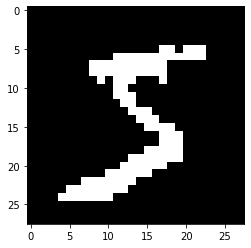

In [8]:
mnist = fetch_openml("mnist_784")
x = mnist.data[0]
binarized_img = (x > 127).astype(np.int).reshape(28, 28)
plt.imshow(binarized_img, cmap="gray")

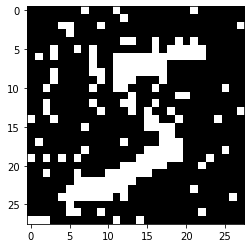

In [9]:
indices = np.random.choice(binarized_img.size, size=int(binarized_img.size * 0.1), replace=False)
noisy_img = np.copy(binarized_img)
noisy_img.ravel()[indices] = 1 - noisy_img.ravel()[indices]
plt.imshow(noisy_img, cmap="gray")

In [10]:
markov_random_field = np.array([
        [[bn.discrete([0.5, 0.5], name=f"p(z_({i},{j}))") for j in range(28)] for i in range(28)], 
        [[bn.DiscreteVariable(2) for _ in range(28)] for _ in range(28)]])
a = 0.9
b = 0.9
pa = [[a, 1 - a], [1 - a, a]]
pb = [[b, 1 - b], [1 - b, b]]
for i, j in itertools.product(range(28), range(28)):
    bn.discrete(pb, markov_random_field[0, i, j], out=markov_random_field[1, i, j], name=f"p(x_({i},{j})|z_({i},{j}))")
    if i != 27:
        bn.discrete(pa, out=[markov_random_field[0, i, j], markov_random_field[0, i + 1, j]], name=f"p(z_({i},{j}), z_({i+1},{j}))")
    if j != 27:
        bn.discrete(pa, out=[markov_random_field[0, i, j], markov_random_field[0, i, j + 1]], name=f"p(z_({i},{j}), z_({i},{j+1}))")
    markov_random_field[1, i, j].observe(noisy_img[i, j], proprange=0)

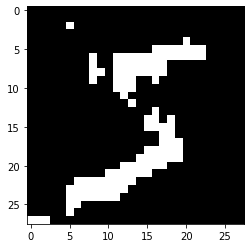

In [11]:
for _ in range(10000):
    i, j = np.random.choice(28, 2)
    markov_random_field[1, i, j].send_message(proprange=3)
restored_img = np.zeros_like(noisy_img)
for i, j in itertools.product(range(28), range(28)):
    restored_img[i, j] = np.argmax(markov_random_field[0, i, j].proba)
plt.imshow(restored_img, cmap="gray")